In [1]:
import lib.setup as sp
import subprocess
import os
conda_env = sp.check_conda_envs()
sp.get_pyjnius(conda_env)
sp.verify_java_home()
# verified the java class path is the default conda env path
# java -version 1.8

Conda environment: /home/loci/anaconda3/envs/cp-notebooks
PYJNIUS_JAR already set: /home/loci/anaconda3/envs/cp-notebooks/share/pyjnius/pyjnius.jar



java enviroment already set
/home/loci/anaconda3/envs/cp-notebooks
jre file is already set


In [2]:
# -- Locate Java installation --

#def is_java_9():
#
#def try_set_java_9():
#    subprocess.check_output(['/usr/libexec/java_home', '-v', '9']).split('\n')
#
# TODO: Require Java 9?

#setenv('JAVA_HOME', '/home/loci/Applications/jdk-9.0.4')


# -- Set up the Java classpath --

# ImageJ
ij_dir = '/home/loci/code/Fiji.app' # FIXME
jars = []
for root, dirs, files in os.walk(ij_dir + '/jars'):
    for file in files:
        if file.endswith('.jar') and \
                not file.startswith('imagej-legacy-') and \
                not file.startswith('ij1-patcher-') and \
                not file.startswith('ij-1.'):
            jars.append(root + '/' + file)
classpath = ":".join(jars)

# ImgLyb
imglyb_dir = conda_env + '/share/imglyb/'
imglyb_jar = imglyb_dir + os.listdir(imglyb_dir)[0]
classpath += ':' + imglyb_jar

os.environ['IMGLYB_JAR'] = classpath
print("Added " + str(len(jars) + 1) + " JARs to the Java classpath.")

Added 261 JARs to the Java classpath.


In [3]:
import json
import os
import StringIO

import cellprofiler.image
import cellprofiler.measurement
import cellprofiler.object
import cellprofiler.pipeline
import cellprofiler.preferences
import cellprofiler.workspace
import imglyb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import jnius
from jnius import JavaException
import skimage.io

/home/loci/anaconda3/envs/cp-notebooks/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using python < 3. Upgrade to python 3 recommended


In [4]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.iteritems():
        image_set.add(image_name, cellprofiler.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace


def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )


def data2image(data):
    return Image.open(StringIO.StringIO(data))


def show(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

In [5]:
# Spin up the ImageJ context.
ImageJ = jnius.autoclass('net.imagej.ImageJ')
ij = ImageJ()

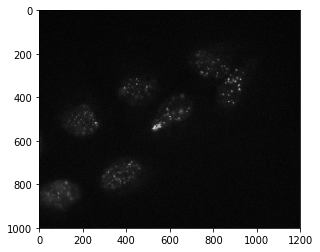

In [6]:
img = skimage.io.imread('data/images/1-162hrh2ax2.tif')
show(img)

In [7]:
HashMap = jnius.autoclass('java.util.HashMap')
input_map = HashMap()
result = ij.command().run("org.scijava.plugins.commands.debug.SystemInformation", True, input_map).get()

#result.getOutputs().toString()    #### AttributeError: 'java.util.Map' object has no attribute 'toString'
# pyjnius is being too strict -- you write foo.toString()
# and it fails because toString is not a Map method (or superinterface of Map method)
# Java compiler knows all objects extend Object, so you can say foo.toString()
# I would call this a bug in pyjnius.

Objects = jnius.autoclass('java.util.Objects')
print('info is ' + str(len(Objects.toString(result.getOutputs()))) + ' characters long.')

info = result.getOutputs().get('info')
# does pyjnius have code to go from [] <-> List and {} <-> Map
# if not: we should write these functions
# https://github.com/kivy/pyjnius/issues/217

info is 363394 characters long.


In [8]:
HashMap = jnius.autoclass('java.util.HashMap')
input_map = HashMap()
print( imglyb.to_imglib(img))
imglib_img = imglyb.to_imglib(img)
input_map.put('display', ij.display().createDisplay(imglib_img))

#class_name = 'net.imagej.plugins.commands.neigh.FindEdges'
#result = ij.command().run(class_name, True, input_map).get()
#Objects.toString(result.getOutputs())

<net/imglib2/python/ReferenceGuardingRandomAccessibleInterval at 0x7f749ef52830 jclass=net/imglib2/python/ReferenceGuardingRandomAccessibleInterval jself=<LocalRef obj=0x5631c94f5950 at 0x7f74c4a61610>>


<net.imagej.display.DefaultImageDisplay at 0x7f749ef52830 jclass=net/imagej/display/DefaultImageDisplay jself=<LocalRef obj=0x5631cb09c510 at 0x7f74c4a616f0>>
<net.imagej.display.DefaultDatasetView at 0x7f749a1b9050 jclass=net/imagej/display/DefaultDatasetView jself=<LocalRef obj=0x7f74c08a06d8 at 0x7f74c4a61750>>
<net.imagej.Dataset at 0x7f749ef52cb0 jclass=net/imagej/Dataset jself=<LocalRef obj=0x5631cae69530 at 0x7f74c4a61b50>>
<net.imglib2.img.Img at 0x7f749a1aa4d0 jclass=net/imglib2/img/Img jself=<LocalRef obj=0x5631cae69480 at 0x7f74c4a61f30>>
imglib_img = <net/imglib2/python/ReferenceGuardingRandomAccessibleInterval at 0x7f749ef52230 jclass=net/imglib2/python/ReferenceGuardingRandomAccessibleInterval jself=<LocalRef obj=0x5631c94f58c8 at 0x7f74c4a618b0>>


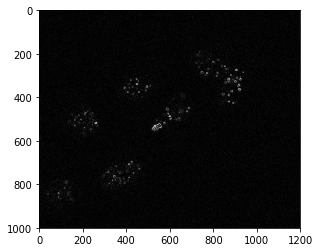

In [9]:
class_name = 'net.imagej.plugins.commands.neigh.FindEdges'
output = ij.command().run(class_name, True, input_map).get()
display = output.getOutputs().get('display')
print(display)
print(display.get(0))
dataset = display.get(0).getData()
print(dataset)
unwrapped_img = dataset.getImgPlus().getImg()
print(unwrapped_img)
print('imglib_img = ' + str(imglib_img))
show(img)

java.lang.NullPointerException
	at net.imagej.ops.morphology.erode.ListErode.createOutput(ListErode.java:112)
	at net.imagej.ops.morphology.erode.ListErode.createOutput(ListErode.java:66)
	at net.imagej.ops.special.hybrid.BinaryHybridCF.createOutput(BinaryHybridCF.java:92)
	at net.imagej.ops.special.hybrid.UnaryHybridCF.createOutput(UnaryHybridCF.java:90)
	at net.imagej.ops.morphology.erode.ListErode.conforms(ListErode.java:83)
	at net.imagej.ops.DefaultOpMatchingService.moduleConforms(DefaultOpMatchingService.java:490)
	at net.imagej.ops.DefaultOpMatchingService.filterMatches(DefaultOpMatchingService.java:293)
	at net.imagej.ops.DefaultOpMatchingService.filterMatches(DefaultOpMatchingService.java:138)
	at net.imagej.ops.DefaultOpMatchingService.findMatch(DefaultOpMatchingService.java:95)
	at net.imagej.ops.OpEnvironment.op(OpEnvironment.java:237)
	at net.imagej.ops.OpEnvironment.op(OpEnvironment.java:219)
	at net.imagej.ops.special.SpecialOp.op(SpecialOp.java:308)
	at net.imagej.ops.s

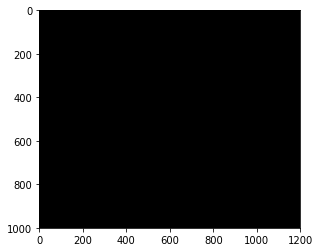

In [10]:
# Enhance edges using ImageJ's morphology.topHat op.

ArrayList = jnius.autoclass('java.util.ArrayList')
HyperSphereShape = jnius.autoclass('net.imglib2.algorithm.neighborhood.HyperSphereShape')
Views = jnius.autoclass('net.imglib2.view.Views')
TopHat = jnius.autoclass('net.imglib2.algorithm.morphology.TopHat')

enhanced = np.zeros(img.shape, dtype=img.dtype)
#ImgView = jnius.autoclass('net.imglib2.img.ImgView')
#java_img = imglyb.to_imglib(img)
#img_factory = ij.op().run("create.imgFactory", java_img)
#img_view = ImgView.wrap(java_img, img_factory)
java_out = Views.iterable(imglyb.to_imglib(enhanced))
java_in = imglyb.to_imglib(img)
shapes = ArrayList()
shapes.add(HyperSphereShape(5))
try:
    #TopHat.topHat(java_in, java_out, HyperSphereShape(5), 1)
    ij.op().morphology().topHat(java_out, java_in, shapes)
except jnius.JavaException as exc:
    print("\n\tat ".join(exc.stacktrace))
show(enhanced)

In [11]:
images = {
    'EnhancedGreen': enhanced,
    'OrigBlue': skimage.io.imread('data/images/1-162hrhoe2.tif'),
    'OrigGreen': img
}

pipeline_filename = 'data/ExampleSpeckles.cppipe'

workspace = run_pipeline(pipeline_filename, images)

/home/loci/anaconda3/envs/cp-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:527: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  np.issubdtype(hdf5_type, int) or
/home/loci/anaconda3/envs/cp-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:529: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  hdf5_type_is_float = np.issubdtype(hdf5_type, float)
/home/loci/anaconda3/envs/cp-notebooks/lib/python2.7/site-packages/centrosome/cpmorphology.py:413: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  index_i, index_j, image = prepare_for_index_lookup(image,

In [12]:
df = objects2df(workspace.measurements, "Nuclei")
df.head()

ValueError: could not broadcast input array from shape (0) into shape (6)

In [ ]:
nuclei = workspace.object_set.get_objects("Nuclei")
skimage.io.imshow(nuclei.segmented)